<a href="https://colab.research.google.com/github/MoritzHaw/BPI2019_Colabatory/blob/main/DataOverview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pie Charts to get a better understanding of the data

In [1]:
%pip install pm4py

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
  Created wheel for stringdist: filename=StringDist-1.0.9-cp37-cp37m-linux_x86_64.whl size=23593 sha256=e0f10d5cf01cd39ecf03dff0bce11a77579294cef8c8c3ec0ffb2302f84b3bba
  Stored in directory: /root/.cache/pip/wheels/d7/9c/d4/63bc3d8931de0980b9e4a724dea290bb40b8b1b2bd6227c8da
Successfully built stringdist


In [2]:
import pm4py
import numpy as np
import pandas as pd

In [3]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

log_csv = pd.read_csv('http://icpmconference.org/2019/wp-content/uploads/sites/6/2019/02/BPIChallenge2019CSV.zip', 
                      encoding='cp1252',sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

In [ ]:
log_csv

In [26]:
log_csv.rename(columns={'eventID':'eventID', 'case Spend area text': 'case:spend:area', 'case Company': 'case:company', 
                        'case Document Type':'case:doc:type', 'case Sub spend area text': 'case:spend:area:text',
                        'case Purchasing Document':'case:doc:id', 'case Purch. Doc. Category name':'case:purch:category',
                        'case Vendor':'case:vendor', 'case Item Type': 'case:item:type', 'case Item Category': 'case:item:category',
                        'case Spend classification text':'case:purch:class',	'case Source': 'case:source',
                        'case Name':'case:vendor:name', 'case GR-Based Inv. Verif.': 'case:invoicing:required', 
                        'case Item': 'case:item','case concept:name': 'case:concept:name', 'case Goods Receipt': 'case:goods:receipt', 
                        'event User': 'event:user', 'event org:resource': 'org:resource', 'event concept:name': 'concept:name',
                        'event Cumulative net worth (EUR)': 'cumulative:net:worth:EUR', 'event time:timestamp': 'time:timestamp'}, 
              inplace=True)

In [25]:
def to_eventlog(dataset):
  # Convert log_csv to event_log
  parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'} 
  # identify the case_id_key name (if not change it will simply be the nane of the coloumn)
  
  event_log = log_converter.apply(dataset, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)
  return event_log


In [21]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
    

def count_occurences(column: str, dataset): 
        """
        count occurences of columns to picture them in a donut chart
        return: counted occurences of column values
        """
        count_column = dataset.groupby(column).count()
        return count_column

def group_lower_ranking_values(column, dataset):  
        '''
        group smallest counts to get a higher visibility
        return: dataset filtered by rating 
        '''
        rating_counts = dataset.groupby(column).count()
        pct_value = rating_counts[lambda x: 
                                  x.columns[0]].quantile(.75) 
                                  # 75 quantile 
        values_below_pct_value = rating_counts[lambda x:
                                  x.columns[0]].loc[lambda s: 
                                  s < pct_value].index.values

        def fix_values(row):
            if row[column] in values_below_pct_value:
                row[column] = 'Other'
            return row

        rating_grouped = log_csv.apply(fix_values, 
                                       axis=1).groupby(column).count()
        return rating_grouped



def pie_chart(column: str, dataset):

        count_column = count_occurences(column, dataset)
        #count_column = group_lower_ranking_values(column, dataset)

        type_labels = count_column['case:concept:name'].sort_values(ascending=False).index
        type_counts = count_column['case:concept:name'].sort_values(ascending=False)
        total = sum(type_counts)

        plt.figure(1, figsize=(15, 15))  # size
        the_grid = GridSpec(2, 2)
        #cmap = plt.get_cmap('tab20c')
        #reversed_cmap = cmap.reversed()
        colors = sns.color_palette('muted')[0:len(type_counts)]
        #colors = [reversed_cmap(i) for i in np.linspace(0, 1, 8)]

        plt.subplot(the_grid[0, 0], aspect=1)
        type_spend_areas = plt.pie(type_counts, shadow=True, colors=colors, 
                                   wedgeprops= { 'linewidth' : 1, 'edgecolor' : 'white' })
        plt.legend(bbox_to_anchor=(1, 1),frameon=False, loc='upper left', 
                   labels=["%s: %1.2f%%" % (i, (float(p)/total)*100) for i, p in 
                           zip(type_labels, type_counts)])

        plt.show()

In [24]:
def donut_pie(column: str, dataset):
        count_column = count_occurences(column, dataset)
        #count_column = group_lower_ranking_values(column, dataset)
        
        type_labels = count_column['case:concept:name'].sort_values(
            ascending=False).index
        type_counts = count_column['case:concept:name'].sort_values(
            ascending=False)
        total = sum(type_counts)

        #print(type_counts)

        plt.figure(1, figsize=(5, 5))  # size
      
        the_grid = GridSpec(2, 2)

        #cmap = plt.get_cmap('tab20c')
        #reversed_cmap = cmap.reversed()
        colors = sns.color_palette('muted')[0:len(type_counts)]
        # colors = [reversed_cmap(i) for i in np.linspace(0, 1, 8)]

        # Create a circle at the center of the plot
        my_circle = plt.Circle( (0,0), 0.7, color='white')

        # Give color names
        plt.pie(type_counts, shadow=True, colors=colors, 
                wedgeprops= { 'linewidth' : 1, 'edgecolor' : 'white' })
        plt.legend(frameon=False, bbox_to_anchor=(1,1), 
                loc='upper left', labels=["%s: %1.2f%%" % 
                (i, (float(p)/total)*100) for i, p in 
                zip(type_labels, type_counts)])
        p = plt.gcf()
        p.gca().add_artist(my_circle)

        plt.show()

In [ ]:
donut_pie('case:spend:area', log_csv)

In [ ]:
donut_pie('case:item:type', log_csv)

In [ ]:
donut_pie('case:item:category', log_csv)

In [ ]:
donut_pie('case:doc:type', log_csv)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


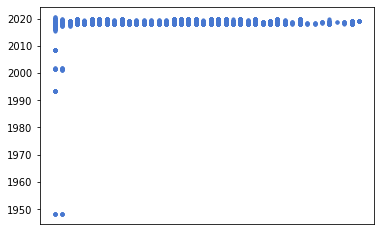

In [51]:
# create scatterplot
import matplotlib.pyplot as plt

scatterplot = plt.scatter(log_csv['concept:name'], log_csv['time:timestamp'], 
                          s=10, c=sns.color_palette('muted')[0])
#plt.xlabel('Cases')
scatterplot.axes.get_xaxis().set_visible(False)
